Import Libraries

In [1]:
# Import necessary libraries for our analysis
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Feature Engineering Function


In [2]:
def add_enhanced_features(df):
    """
    Creates meaningful features from customer ratings to better understand satisfaction patterns.
    Input: DataFrame with original survey responses (X1-X6)
    Output: DataFrame with additional engineered features
    """
    df = df.copy()
    ratings = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']]

    # Create rating-based metrics
    df['excellent_ratings'] = (ratings >= 4.5).sum(axis=1)  # Count of very high ratings
    df['poor_ratings'] = (ratings <= 2.5).sum(axis=1)      # Count of very low ratings

    # Create service quality indicators
    df['service_interaction'] = df['X1'] * df['X5']  # Delivery time × Courier satisfaction
    df['quality_price_ratio'] = df['X2'] * df['X3'] / df['X4']  # Value for money
    df['consistent_service'] = ((df['X1'] >= 4) & (df['X5'] >= 4) & (df['X6'] >= 4)).astype(int)
    df['service_failure'] = ((df['X1'] <= 2) | (df['X5'] <= 2) | (df['X6'] <= 2)).astype(int)

    # Create satisfaction scores
    df['delivery_satisfaction'] = df['X1'] * (6 - df['poor_ratings'])
    df['price_satisfaction'] = df['X4'] * (6 - df['poor_ratings'])

    return df

Load and Process Data

In [3]:
# Upload your data file to Colab first
from google.colab import files
uploaded = files.upload()  # Upload ACME-HappinessSurvey2020.csv

# Read and process the data
df = pd.read_csv('ACME-HappinessSurvey2020.csv')
df_processed = add_enhanced_features(df)

# Define features for our models
features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6',
           'service_interaction', 'quality_price_ratio',
           'excellent_ratings', 'poor_ratings',
           'consistent_service', 'service_failure',
           'delivery_satisfaction', 'price_satisfaction']

X = df_processed[features]
y = df_processed['Y']

# Look at our processed data
print("Original data shape:", df.shape)
print("Processed data shape:", df_processed.shape)
print("\nFirst few rows of processed data:")
print(df_processed.head())

Saving ACME-HappinessSurvey2020.csv to ACME-HappinessSurvey2020 (1).csv
Original data shape: (126, 7)
Processed data shape: (126, 15)

First few rows of processed data:
   Y  X1  X2  X3  X4  X5  X6  excellent_ratings  poor_ratings  \
0  0   3   3   3   4   2   4                  0             1   
1  0   3   2   3   5   4   3                  1             1   
2  1   5   3   3   3   3   5                  2             0   
3  0   5   4   3   3   3   5                  2             0   
4  0   5   4   3   3   3   5                  2             0   

   service_interaction  quality_price_ratio  consistent_service  \
0                    6                 2.25                   0   
1                   12                 1.20                   0   
2                   15                 3.00                   0   
3                   15                 4.00                   0   
4                   15                 4.00                   0   

   service_failure  delivery_satisfac

Data Preparation and Scaling

In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale our features to make sure they're all on the same scale
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Let's look at our data splits
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

Training set shape: (100, 14)
Testing set shape: (26, 14)

Class distribution in training set:
Y
1    0.58
0    0.42
Name: proportion, dtype: float64


Model Definition

In [5]:
# Define our three models with carefully chosen parameters
models = {
    'Decision Tree': DecisionTreeClassifier(
        max_depth=4,          # Limit tree depth to prevent overfitting
        min_samples_split=5,  # Need at least 5 samples to create a split
        random_state=42       # For reproducible results
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,     # Use 200 trees in the forest
        max_depth=5,          # Each tree has maximum depth of 5
        min_samples_split=5,  # Need 5 samples to split
        min_samples_leaf=2,   # Need at least 2 samples in each leaf
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        max_depth=4,
        learning_rate=0.05,   # Small learning rate for better learning
        n_estimators=200,     # Build 200 trees sequentially
        min_child_weight=2,
        subsample=0.8,        # Use 80% of data for each tree
        colsample_bytree=0.8, # Use 80% of features for each tree
        random_state=42
    )
}

print("Models defined and ready for training!")

Models defined and ready for training!


Model Training and Evaluation

In [6]:
# Initialize dictionaries to store results
results = {}
predictions = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred

    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'report': classification_report(y_test, y_pred, output_dict=True)
    }

    # Print initial results
    print(f"{name} Accuracy: {results[name]['accuracy']:.3f}")


Training Decision Tree...
Decision Tree Accuracy: 0.423

Training Random Forest...
Random Forest Accuracy: 0.577

Training XGBoost...
XGBoost Accuracy: 0.654


Model Comparison Visualizations

In [7]:
def create_comparison_visualizations():
    """Creates comprehensive visualizations comparing all three models."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Model Accuracy Comparison
    accuracies = [results[model]['accuracy'] for model in models.keys()]
    sns.barplot(x=list(models.keys()), y=accuracies, ax=axes[0,0])
    axes[0,0].set_title('Model Accuracy Comparison')
    axes[0,0].set_ylabel('Accuracy Score')
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

    # Predictions vs Actual Values
    test_indices = range(len(y_test))
    axes[0,1].plot(test_indices, y_test.values, 'ko-', label='Actual', alpha=0.7)
    colors = ['r', 'b', 'g']
    for (name, pred), color in zip(predictions.items(), colors):
        axes[0,1].plot(test_indices, pred, color + 'o--', label=name, alpha=0.5)
    axes[0,1].set_title('Predictions vs Actual Values')
    axes[0,1].set_xlabel('Test Sample Index')
    axes[0,1].set_ylabel('Customer Happiness (0/1)')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Confusion Matrices
    for idx, (name, result) in enumerate(list(results.items())[:2]):
        sns.heatmap(result['confusion_matrix'],
                   annot=True, fmt='d', ax=axes[1,idx], cmap='Blues')
        axes[1,idx].set_title(f'{name} Confusion Matrix')
        axes[1,idx].set_xlabel('Predicted')
        axes[1,idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Create separate figure for XGBoost confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(results['XGBoost']['confusion_matrix'],
                annot=True, fmt='d', cmap='Blues')
    plt.title('XGBoost Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Print Detailed Results

In [10]:
def print_detailed_comparison():
    """Prints detailed comparison of all three models."""
    print("\nDetailed Model Comparison:")
    print("-" * 50)

    for name, result in results.items():
        print(f"\n{name}:")
        print(f"Accuracy: {result['accuracy']:.3f}")
        report = result['report']
        print("\nUnhappy Customers (0):")
        print(f"  Precision: {report['0']['precision']:.3f}")
        print(f"  Recall: {report['0']['recall']:.3f}")
        print("Happy Customers (1):")
        print(f"  Precision: {report['1']['precision']:.3f}")
        print(f"  Recall: {report['1']['recall']:.3f}")


    print("\nTop 5 Important Features by Model:")
    print("-" * 50)
    for name, model in models.items():
        importance = pd.DataFrame({
            'feature': features,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head()
        print(f"\n{name} Important Features:")
        print(importance)

Generating Visualizations

<ipython-input-7-3a0a77e0e2e8>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)


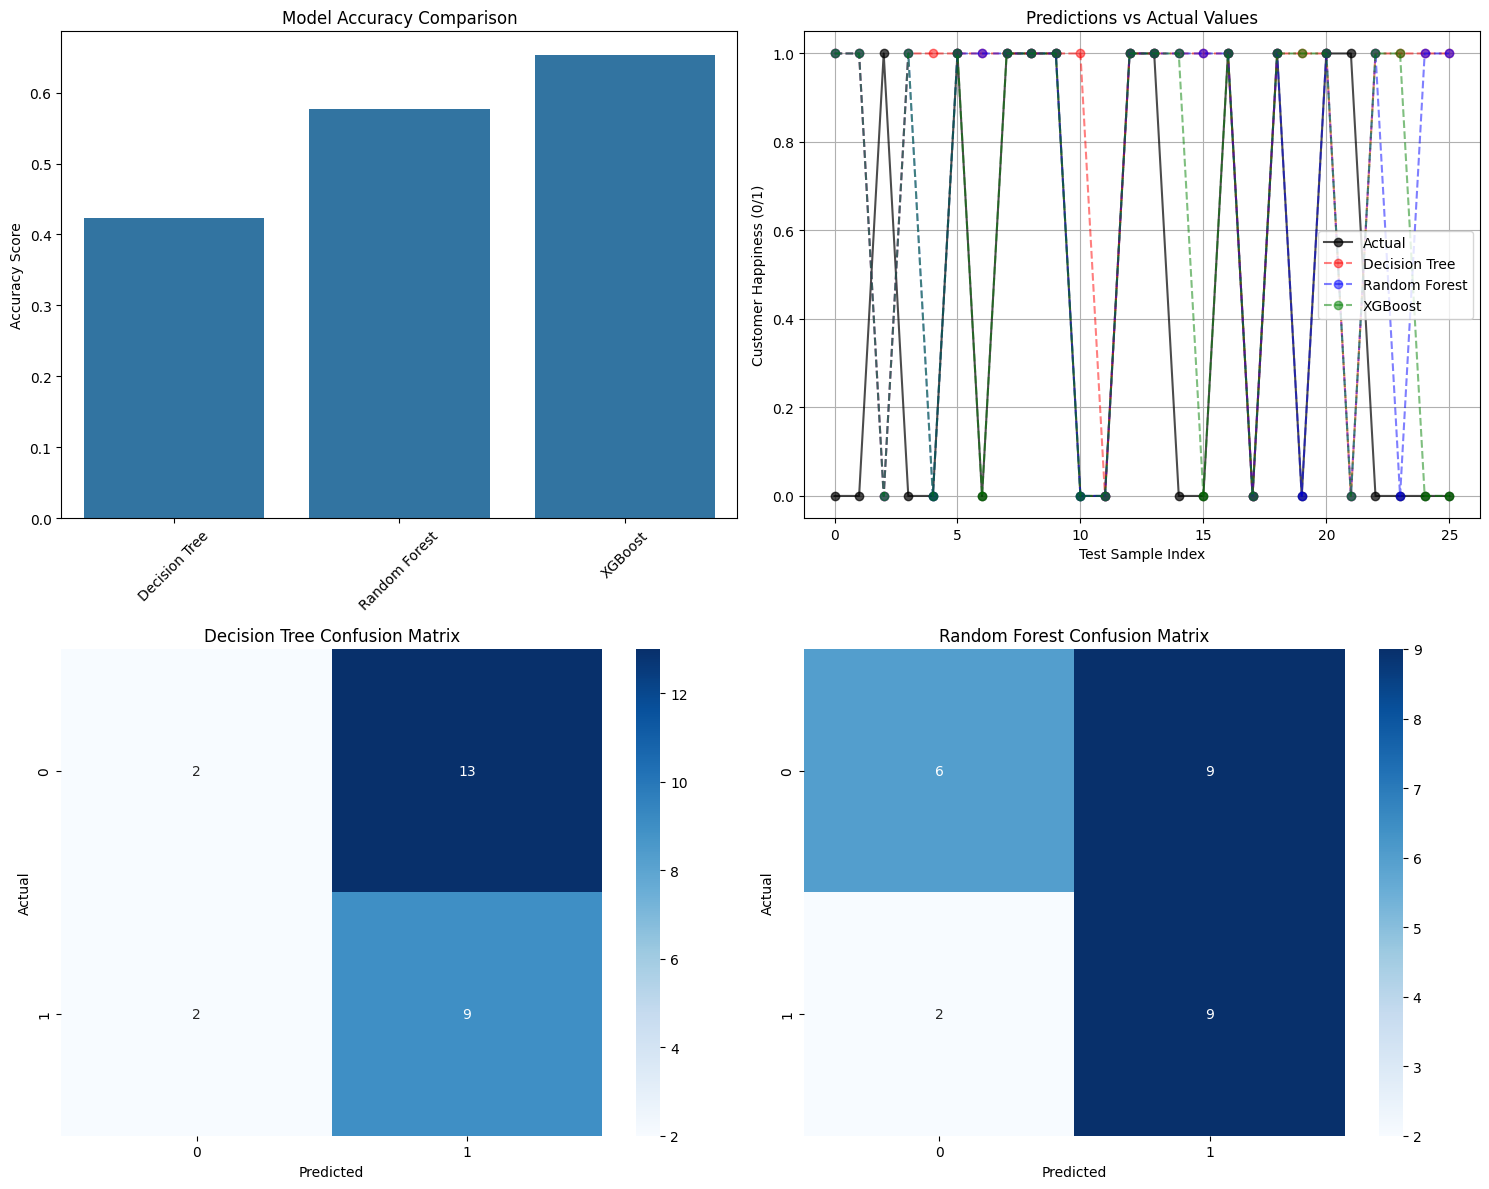

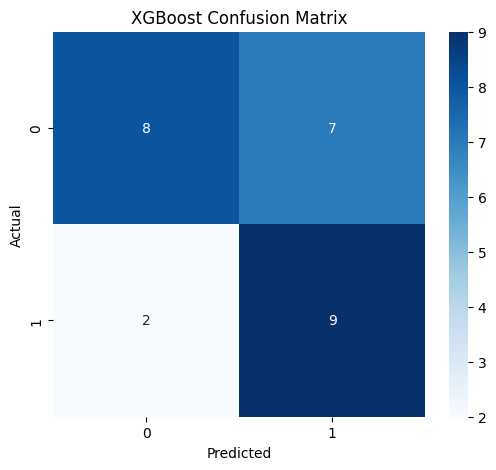


Detailed Model Comparison:
--------------------------------------------------

Decision Tree:
Accuracy: 0.423

Unhappy Customers (0):
  Precision: 0.500
  Recall: 0.133
Happy Customers (1):
  Precision: 0.409
  Recall: 0.818

Random Forest:
Accuracy: 0.577

Unhappy Customers (0):
  Precision: 0.750
  Recall: 0.400
Happy Customers (1):
  Precision: 0.500
  Recall: 0.818

XGBoost:
Accuracy: 0.654

Unhappy Customers (0):
  Precision: 0.800
  Recall: 0.533
Happy Customers (1):
  Precision: 0.562
  Recall: 0.818

Top 5 Important Features by Model:
--------------------------------------------------

Decision Tree Important Features:
                  feature  importance
0                      X1    0.296510
5                      X6    0.279612
8       excellent_ratings    0.204126
7     quality_price_ratio    0.175934
12  delivery_satisfaction    0.043817

Random Forest Important Features:
                  feature  importance
6     service_interaction    0.122817
7     quality_price_ratio

In [11]:
# Generate our visualizations and comparisons
create_comparison_visualizations()
print_detailed_comparison()